In [2]:
import numpy as np
import cmath

#визуализация матриц
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#генерация случайных унитарных матриц
from scipy.stats import unitary_group

pi = np.pi

In [3]:
#Класс отдельного ИМЦ с функция, возвращающими его матрицы преобразования

class MZI:
    def __init__(self, N, m, theta, phi):
        self.N = N
        self.m = m
        self.theta = theta
        self.phi = phi
        
    def t_mn(self):
        m = self.m
        
        res = np.eye(self.N, dtype=complex)
        res[m-1][m-1] = np.exp(1j * self.phi) * np.sin(self.theta)#np.exp(1j * self.phi) * np.cos(self.theta)
        res[m][m-1] = np.exp(1j * self.phi) * np.cos(self.theta)#np.exp(1j * self.phi) * np.sin(self.theta)
        res[m-1][m] = np.cos(self.theta)#- np.sin(self.theta)
        res[m][m] = - np.sin(self.theta)#np.cos(self.theta)
    
        return res
    
    def t_mn_inverse(self):
        return np.linalg.inv(self.t_mn())
    
    def show(self):
        print(self.m, ', theta: ', round(self.theta.real, 3), ', phi: ', round(self.phi.real, 3))

In [9]:
#Функция декомпозиции

def decompose(U):
    N = U.shape[0]
    R = U
    mzi_lines = []
    
    for k in range(1, N):
        mzi_line = {'line index': k, 'mzis': []}
        for z in range(1, k + 1):
            
            if k % 2 == 1:
                i = N - z + 1
                j = k - z + 1
                m = k - z + 1
            else:
                i = N - k + z
                j = z
                m = N - k + z - 1
                
            if k % 2 == 1:
                theta = cmath.atan(abs(R[i - 1][m - 1] / R[i - 1][m]))
                phi = cmath.phase(R[i - 1][m - 1] / R[i - 1][m])
                mzi_line['mzis'].append(MZI(N, m, theta, phi))
                R = R @ MZI(N, m, theta, phi).t_mn_inverse()
            else:
                theta = cmath.atan(abs(R[i - 1][j - 1] / R[i - 2][j - 1]))
                phi = cmath.phase((-1) * R[i - 1][j - 1] / R[i - 2][j - 1])
                mzi_line['mzis'].append(MZI(N, m, theta, phi))
                R = MZI(N, m, theta, phi).t_mn() @ R
            
        mzi_lines.append(mzi_line)
        
    #Здесь мы нашли параметры theta и phi, которые приводят матрицу U к диагональному виду (прошли шаг 5 из статьи).
    #Можно проверить, что полученная с помощью преобразований матрица R является диагональной
    #Надейнные параметры еще отличаются от тех, которые будут давать нужное преобразование
    
    D = R #Здесь в итоге должна получиться матрица D'
    final_mzi_lines = [] #Набор линий, его потом вернет функция
    
    #Нечетные линии добавляются без изменения параметров

    for line_index in range(0, len(mzi_lines), 2):
        final_mzi_line = mzi_lines[line_index]   
        final_mzi_lines.append(final_mzi_line)
        
    #Поиск новых параметров четных линий и матрицы D', добавление четных линий
    
    if N % 2 == 1:
        start = N // 2 * 2 - 1
    else:
        start = N // 2 * 2 - 3
    
    for line_index in range(start, 0, -2):
        final_mzi_line = {'line index': line_index + 1, 'mzis': []}
        for mzi in mzi_lines[line_index]['mzis'][::-1]:
            theta_old = mzi.theta
            phi_old = mzi.phi
            m = mzi.m
            
            theta_new = theta_old
            phi_new = pi + cmath.phase(D[m-1][m-1]) - cmath.phase(D[m][m])
            
            final_mzi_line['mzis'].append(MZI(N, m, theta_new, phi_new))
            D = MZI(N, m, theta_old, phi_old).t_mn_inverse() @ D @ MZI(N, m, theta_new, phi_new).t_mn_inverse()
            
        final_mzi_lines.append(final_mzi_line)
        
    #Вывод параметров    
    
    for i in final_mzi_lines:
        print('Line', i['line index'], '\n')
        for j in i['mzis']:
            j.show()
        print('\n')
        
    print('D\' :\n', D)
        
    return [final_mzi_lines, D]

Line 1 

1 , theta:  0.196 , phi:  -1.731


Line 3 

3 , theta:  0.926 , phi:  2.485
2 , theta:  0.0 , phi:  3.108
1 , theta:  0.0 , phi:  1.7


Line 2 

3 , theta:  0.0 , phi:  0.257
2 , theta:  1.209 , phi:  1.036


D' :
 [[ 1.33785218e-01-9.16203200e-02j  1.96045231e-01-1.00294871e-01j
   3.00768306e-01+6.19062580e-02j -1.22435858e-01-9.03288404e-01j]
 [-1.71251612e-01-7.58233819e-02j -3.16524291e-01-3.44167744e-01j
   8.09536139e-01+1.28271007e-01j  1.79121475e-01+2.05907559e-01j]
 [ 2.26030486e-01+4.50613310e-01j  1.89625057e-02+6.57466448e-01j
   3.70255327e-01+2.85569704e-01j -2.90470509e-01+1.01113690e-01j]
 [ 2.27790559e-01-7.95361715e-01j -3.47157851e-01+4.23943231e-01j
  -1.38448973e-03+1.23542908e-01j  5.45722961e-18+1.27116327e-17j]]
[{'line index': 1, 'mzis': [<__main__.MZI object at 0x000002BEA9F73848>]}, {'line index': 3, 'mzis': [<__main__.MZI object at 0x000002BEA9F73C88>, <__main__.MZI object at 0x000002BEA9F73F48>, <__main__.MZI object at 0x000002BEA9F73708>]}, {'li

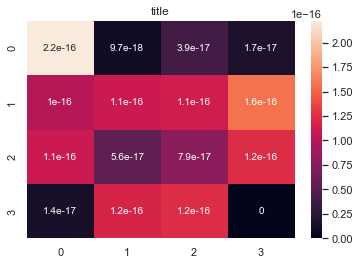

In [ ]:
#Функция для обратной композиции

def compose_back(N, lines, D):
    res = np.eye(N)
    for i in lines:
        for mzi in i['mzis']:
            res = mzi.t_mn() @ res
            
    res = D @ res
    return res
    
def plot_matrix(matrix, title):
    ax = sns.heatmap(matrix, annot=True)
    plt.title(title,fontsize=12)
    plt.show()

N = 4
U = unitary_group.rvs(N)
a = decompose(U)
lines = a[0]
print(lines)
D = a[1]

B = compose_back(N, lines, D)
plot_matrix(np.abs(B - U), 'title')

In [5]:
B

array([[-0.0253191 -0.00264256j,  0.23253852+0.16794591j,
        -0.26008151+0.02471263j, -0.51130048+0.76641417j],
       [ 0.67773374-0.48005368j,  0.04181781-0.01164386j,
         0.02120302+0.53504427j, -0.12256297-0.08122504j],
       [ 0.15956702+0.16916359j, -0.84236232-0.2645638j ,
         0.2285597 +0.01986998j, -0.12403584+0.31358337j],
       [-0.27456394-0.4243985j , -0.34364533-0.13481585j,
        -0.76886014+0.03528027j,  0.10578964-0.06819881j]])

In [6]:
U

array([[-0.0253191 -0.00264256j,  0.23253852+0.16794591j,
        -0.26008151+0.02471263j, -0.51130048+0.76641417j],
       [ 0.67773374-0.48005368j,  0.04181781-0.01164386j,
         0.02120302+0.53504427j, -0.12256297-0.08122504j],
       [ 0.15956702+0.16916359j, -0.84236232-0.2645638j ,
         0.2285597 +0.01986998j, -0.12403584+0.31358337j],
       [-0.27456394-0.4243985j , -0.34364533-0.13481585j,
        -0.76886014+0.03528027j,  0.10578964-0.06819881j]])